In [1]:
!pip install aif360


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.4 MB/s eta 0:00:00


In [2]:
#importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# AI Fairness 360 tools
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# For displaying warnings cleanly
import warnings
warnings.filterwarnings('ignore')


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [4]:
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv


--2025-07-14 17:31:53--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.05s   

2025-07-14 17:31:53 (47.4 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]



In [5]:
# Load CSV into a pandas dataframe
df = pd.read_csv("compas-scores-two-years.csv")

# Show the first few rows
df.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [6]:
# Keep only necessary columns
features_to_keep = [
    'sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count',
    'juv_other_count', 'priors_count', 'c_charge_degree', 'two_year_recid'
]

df = df[features_to_keep]

# Drop rows with missing data
df = df.dropna()


In [8]:
# Encode 'sex': Male → 1, Female → 0
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

# Encode 'race': African-American → 1 (unprivileged), Caucasian → 0 (privileged), Others → 2
def encode_race(race):
    if race == 'African-American':
        return 1
    elif race == 'Caucasian':
        return 0
    else:
        return 2  # other races

df['race'] = df['race'].apply(encode_race)

# Encode 'c_charge_degree': F (felony) → 1, M (misdemeanor) → 0
df['c_charge_degree'] = df['c_charge_degree'].apply(lambda x: 1 if x == 'F' else 0)



In [9]:
from aif360.datasets import BinaryLabelDataset

dataset = BinaryLabelDataset(
    df=df,
    label_names=['two_year_recid'],
    protected_attribute_names=['race'],
    favorable_label=0,
    unfavorable_label=1
)


In [10]:
#defining privileged and unprivileged groups
privileged_groups = [{'race': 0}]       # Caucasian
unprivileged_groups = [{'race': 1}]     # African-American


In [11]:
from aif360.metrics import BinaryLabelDatasetMetric

# Create a metric object
metric = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Print fairness metrics
print("Difference in mean outcomes (disparate impact):", metric.mean_difference())
print("Disparate impact (ratio):", metric.disparate_impact())
print("Statistical parity difference:", metric.statistical_parity_difference())


Difference in mean outcomes (disparate impact): -0.12069679505498576
Disparate impact (ratio): 0.8009476242843179
Statistical parity difference: -0.12069679505498576


In [12]:
# Split into two groups
dataset_privileged = dataset.subset(dataset.protected_attributes[:, 0] == 0)  # Caucasian
dataset_unprivileged = dataset.subset(dataset.protected_attributes[:, 0] == 1)  # African-American


In [13]:
#simulate classifier output
dataset_pred = dataset.copy()
dataset_pred.labels = dataset.labels.copy()  # Dummy "predictions"


In [14]:
#Compute Group-Level Performance Metrics
from aif360.metrics import ClassificationMetric

metric_pred = ClassificationMetric(
    dataset,
    dataset_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Get the False Positive Rate and True Positive Rate
fpr_unpriv = metric_pred.false_positive_rate(False)
fpr_priv = metric_pred.false_positive_rate(True)

tpr_unpriv = metric_pred.true_positive_rate(False)
tpr_priv = metric_pred.true_positive_rate(True)

print("False Positive Rate (African-American):", fpr_unpriv)
print("False Positive Rate (Caucasian):", fpr_priv)
print("True Positive Rate (African-American):", tpr_unpriv)
print("True Positive Rate (Caucasian):", tpr_priv)


False Positive Rate (African-American): 0.0
False Positive Rate (Caucasian): 0.0
True Positive Rate (African-American): 1.0
True Positive Rate (Caucasian): 1.0


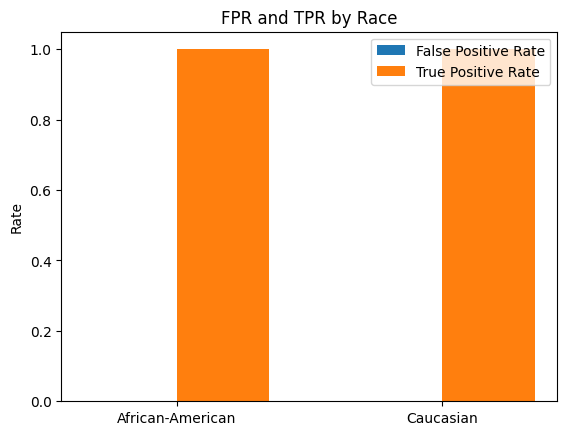

In [15]:
#bar plot vizualization

# Labels and values
groups = ['African-American', 'Caucasian']
fprs = [fpr_unpriv, fpr_priv]
tprs = [tpr_unpriv, tpr_priv]

# Plot
x = np.arange(len(groups))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, fprs, width, label='False Positive Rate')
bars2 = ax.bar(x + width/2, tprs, width, label='True Positive Rate')

ax.set_ylabel('Rate')
ax.set_title('FPR and TPR by Race')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()

plt.show()
